# Data

In [1]:
import pandas as pd

In [2]:
file = 'fund_monthly_241229.csv'
path = '.'
df_prc = pd.read_csv(
    f'{path}/{file}',
    parse_dates=['date'],
    dtype={'ticker': str},
    index_col=['group', 'ticker', 'date']
)

In [3]:
file = 'fund_name_241230.csv'
fund_name = pd.read_csv(f'{path}/{file}', dtype={'ticker': str}, index_col=[0]).iloc[:,0].to_dict()

In [4]:
calc_cagr = lambda year: (df_prc['price_after_fees']
                          .groupby('ticker', group_keys=False).apply(lambda x: x.pct_change(year*12).dropna())
                          .groupby('group').agg(['mean', 'std'])
                          .mul(100).round(1)
                          .apply(lambda x: f"{x['mean']:.1f} ± {x['std']:.1f}", axis=1)
                          #.apply(lambda x: f"{x['mean']:.1%} ± {x['std']:.1%}", axis=1)
                         )

df = (df_prc.groupby('group').apply(lambda x: x.index.get_level_values(1).nunique()).to_frame('n')
      .join(calc_cagr(1).rename('1y')).join(calc_cagr(3).rename('3y')))
df

,n,1y,3y
group,,,
2025,2,4.8 ± 8.4,12.6 ± 9.6
2030,12,4.9 ± 10.3,13.1 ± 11.0
2035,9,6.0 ± 11.6,16.6 ± 12.0
2040,9,6.5 ± 12.5,17.9 ± 12.7
2045,8,6.6 ± 13.1,17.9 ± 12.7
2050,6,6.8 ± 13.8,12.8 ± 10.4
2055,1,7.2 ± 10.9,23.1 ± 1.6


# Bayesian

In [5]:
from ddf_utils import BayesianEstimator

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [6]:
df_p = df_prc['price_after_fees'].droplevel(0).unstack('ticker')

In [15]:
years = 3
days_in_year = 12 # months
freq = years*12 # months

file_est = f'tdf_ror_{years}y'

## Estimate

In [16]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund_name
)
be = BayesianEstimator(df_p, **kw)

In [18]:
be.bayesian_sample(freq=freq, file=file_est)

/home/lbk/works/pf/pages/ddf_utils.py:257: FutureWarning: The `testval` argument is deprecated; use `initval`.
  nu = pm.Exponential('nu_minus_two', 1 / rate_nu, testval=4) + 2.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_two, mu, sig, ror]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.


./tdf_ror_3y.pkl saved


### load

In [19]:
kw = dict(
    days_in_year = days_in_year,
    security_names = fund_name
)
be = BayesianEstimator.create(file_est, **kw)

./tdf_ror_3y.pkl loaded


## Analysis

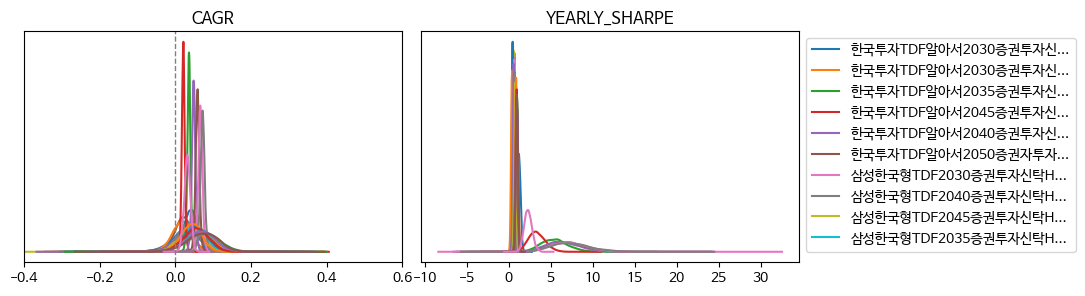

In [20]:
_ = be.plot_returns(max_legend=10)

In [34]:
var_name = 'cagr'
sort_by = 'hdi_3%'

df = be.bayesian_summary(var_name).droplevel(0).sort_values('hdi_3%', ascending=False)
t = df.loc[df[sort_by]>0].index.to_list()
len(t)

8

In [37]:
#df.head()
df_tmp = df.loc[t].iloc[:, :4]
df_tmp.index = [fund_name[x] for x in df_tmp.index]
df_tmp

,mean,sd,hdi_3%,hdi_97%
IBK로우코스트TDF2055증권자투자신탁[혼합-재간접형]종류C-Re,0.072,0.006,0.059,0.083
IBK로우코스트TDF2050증권자투자신탁[혼합-재간접형]종류C-Re,0.066,0.006,0.055,0.077
IBK로우코스트TDF2045증권자투자신탁[혼합-재간접형]종류C-Re,0.058,0.005,0.049,0.069
IBK로우코스트TDF2040증권자투자신탁[혼합-재간접형]종류C-Re,0.048,0.005,0.039,0.058
IBK로우코스트TDF2035증권자투자신탁[혼합-재간접형]종류C-Re,0.036,0.004,0.027,0.044
미래에셋전략배분TDF2050혼합자산자투자신탁종류C-P2e,0.031,0.008,0.016,0.047
IBK로우코스트TDF2030증권자투자신탁[혼합-재간접형]종류C-Re,0.021,0.004,0.013,0.029
신한마음편한TDF2050증권투자신탁[주식혼합-재간접형](종류C-re),0.039,0.019,0.003,0.073


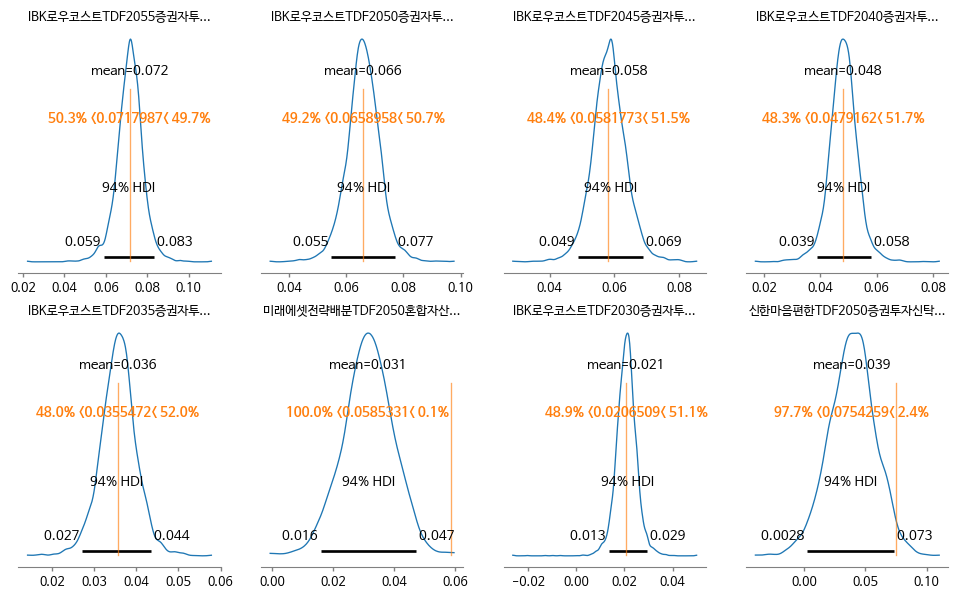

In [38]:
be.plot_posterior(var_name, t, figsize=(12,7), textsize=9)